In [3]:
from sysdata.sim.csv_futures_sim_data import csvFuturesSimData
from paper.systems.simplesystem import simplesystem
from ctse.systems.ct_system import ct_system
import pandas as pd
import matplotlib.pyplot as plt

system = simplesystem(csvFuturesSimData(), 'paper.systems.simplesystemconfig.yaml')
rawdata = system.rawdata
data = system.data

2022-11-17 09:29:15 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-11-17 09:29:15 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-11-17 09:29:15 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-11-17 09:29:15 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)
2022-11-17 09:29:15 {'type': 'csvFuturesSimData'} [Warning] No datapaths provided for .csv, will use defaults  (may break in production, should be fine in sim)


In [42]:
adjust_price  = data.daily_prices("A")
contract_price = rawdata.daily_denominator_price("A")
daily_returns = adjust_price.diff() / contract_price

<AxesSubplot: xlabel='vol', ylabel='this_month_return'>

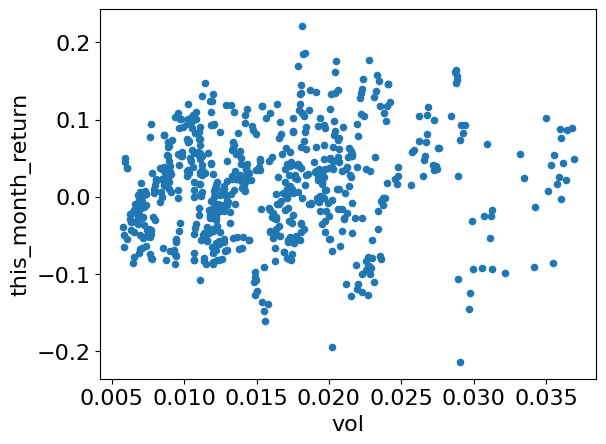

In [188]:
from sysquant.estimators.vol import simple_ewvol_calc

ins = 'RB'
adjust_price  = data.daily_prices(ins)
contract_price = rawdata.daily_denominator_price(ins)
daily_returns = adjust_price.diff() / contract_price
vol = daily_returns.rolling(30).std().rename('vol')
next_month_return = ((adjust_price.shift(-21) - adjust_price) / contract_price).rename('next_month_return')
next_month_vol = daily_returns.shift(-21).rolling(21).std().rename('next_month_vol')
this_month_return = ((adjust_price - adjust_price.shift(21)) / contract_price.shift(21)).rename('this_month_return')
plt.show()
pd.concat([vol, this_month_return], axis=1).sort_values('vol').plot.scatter(x='vol', y='this_month_return')


In [44]:
# import numpy as np

# df = pd.concat([vol, next_month_vol], axis=1)
# np.array_split(daily_returns, 5)[-1].tail(50)
# # .plot.scatter(x='vol', y='next_month_vol')

In [76]:
sector = system.data.all_instruments_in_asset_class('Black')

perc_returns = [rawdata.get_daily_percentage_returns(instrument_code).rename(instrument_code) for instrument_code in sector]
perc_returns_df = pd.concat(perc_returns, axis=1)
# use_returns =  perc_returns_df.resample("5B").sum()
use_returns = perc_returns_df

def get_forecast_and_future_corr(Nweeks_back, Nweeks_forward):
    forecast = get_historic_correlations(Nweeks_back)
    future = get_future_correlations(Nweeks_forward)

    pd_result = merge_forecast_and_future(forecast, future, Nweeks_forward)

    return pd_result

def merge_forecast_and_future(forecast, future, Nweeks_forward):
    assets = forecast.columns # should be the same won't check
    pd_result = []
    for asset in assets:
        result_for_asset = pd.concat([forecast[asset], future[asset]], axis=1)
        # remove tail with nothing
        result_for_asset = result_for_asset[:-Nweeks_forward]

        # remove overlapping periods which bias R^2
        selector = range(0, len(result_for_asset.index), Nweeks_forward)
        result_for_asset = result_for_asset.iloc[selector]

        result_for_asset.columns = ['forecast', 'turnout']
        pd_result.append(result_for_asset)

    pd_result = pd.concat(pd_result, axis=0)

    return pd_result

def get_future_correlations(Nweeks_forward):
    corr = get_rolling_correlations(use_returns, Nweeks_forward)
    corr = corr.ffill()
    future_corr = corr.shift(-Nweeks_forward)

    return future_corr

def get_historic_correlations(Nweeks_back):
    corr = get_rolling_correlations(use_returns, Nweeks_back)
    corr = corr.ffill()

    return corr

def get_rolling_correlations(use_returns, Nperiods, perm_names=None):
    roll_df = use_returns.rolling(Nperiods, min_periods=4).corr()
    if perm_names is None:
        perm_names = get_asset_perm_names(use_returns)
    roll_list = [get_rolling_corr_for_perm_pair(perm_pair, roll_df) for perm_pair in perm_names]
    roll_list_df = pd.concat(roll_list, axis=1)
    roll_list_df.columns = ["%s/%s" % (asset1, asset2) for (asset1, asset2) in perm_names]

    return roll_list_df

def get_asset_perm_names(use_returns):
    asset_names = use_returns.columns
    permlist = []
    for asset1 in asset_names:
        for asset2 in asset_names:
            if asset1==asset2:
                continue
            pairing = [asset1, asset2]
            if pairing in permlist:
                continue
            pairing.reverse()
            if pairing in permlist:
                continue

            permlist.append(pairing)

    return permlist

def get_interclass_asset_perm_names(asset_names, other_asset_names):
    permlist = []
    for asset1 in asset_names:
        for asset2 in other_asset_names:
            if asset1==asset2:
                continue
            pairing = [asset1, asset2]
            if pairing in permlist:
                continue
            pairing.reverse()
            if pairing in permlist:
                continue

            permlist.append(pairing)

    return permlist

def get_rolling_corr_for_perm_pair(perm_pair, roll_df):
    return roll_df[perm_pair[0]][:,perm_pair[1]]

rolling_correlations = get_rolling_correlations(use_returns, 52).dropna()

<AxesSubplot: xlabel='index'>

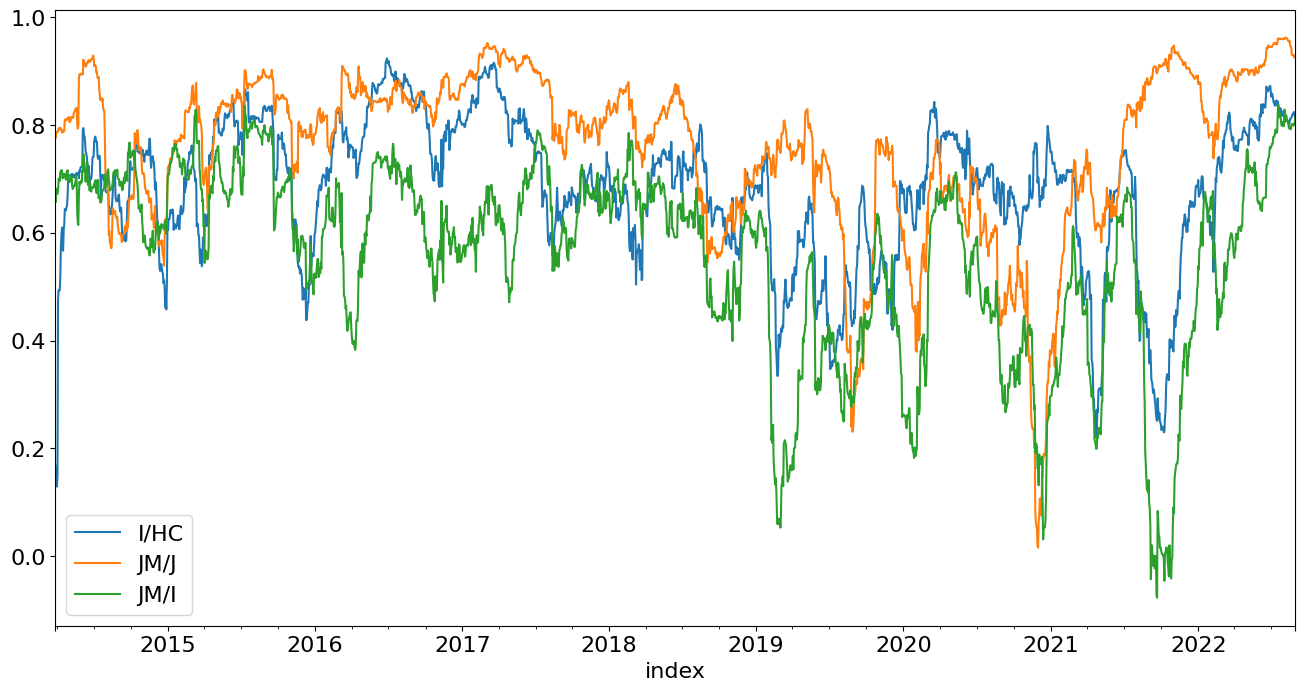

In [46]:
rolling_correlations.sample(3, axis=1).plot(figsize=(16,8))

4
7
13
26
52
104
208
520
1040


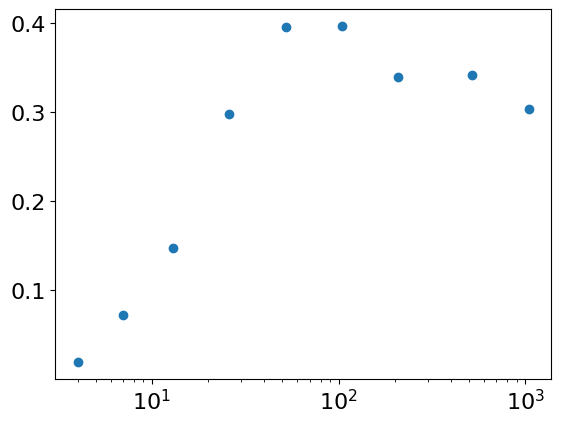

In [47]:
Nweeks_forward = 52 # use 13 weeks for underlying returns, 52 for others

import statsmodels.api as sm
import matplotlib.pyplot as pyplot
pyplot.rcParams.update({'font.size': 16})

Nweeks_list = [4, 7, 13, 26,52, 104, 208, 520, 520 * 2]
r_squared = []
for Nweeks_back in Nweeks_list:
    print(Nweeks_back)
    pd_result = get_forecast_and_future_corr(Nweeks_back, Nweeks_forward)

    pd_result = pd_result.dropna()

    x = pd_result.forecast
    x = sm.add_constant(x)
    y = pd_result.turnout
    est = sm.OLS(y, x).fit()
    r2 = est.rsquared_adj
    r_squared.append(r2)

ax = pyplot.gca()
ax.scatter(Nweeks_list, r_squared)
ax.set_xscale('log')

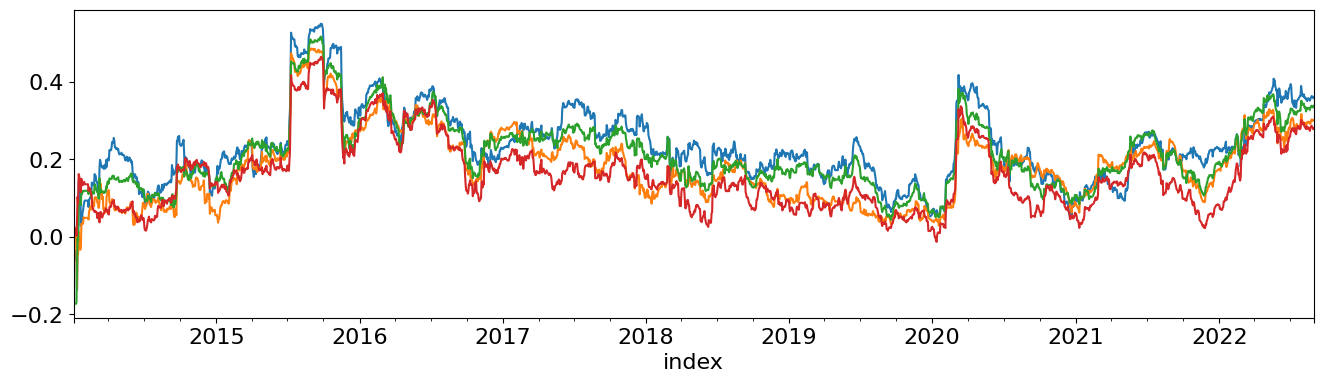

<AxesSubplot: xlabel='index'>

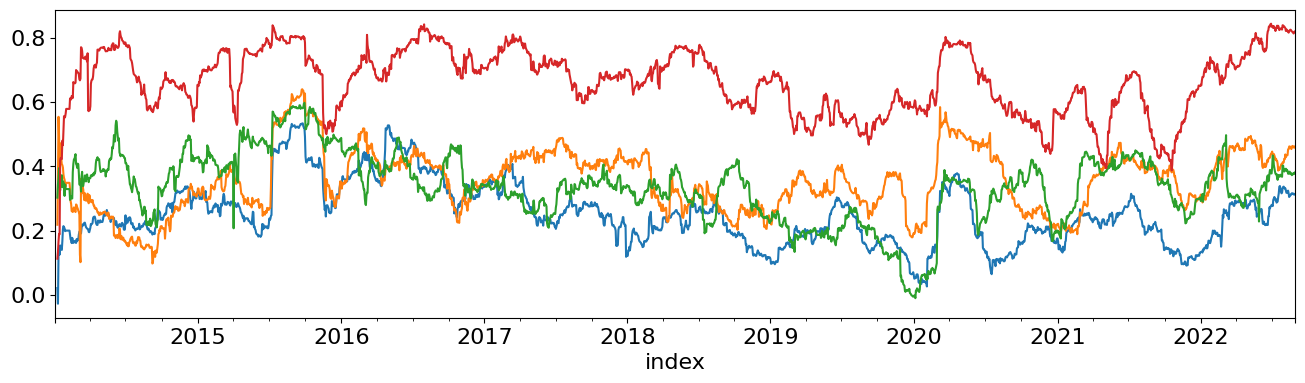

In [82]:
a = system.data.all_instruments_in_asset_class('Black')
b = system.data.all_instruments_in_asset_class('Metals')
c = system.data.all_instruments_in_asset_class('Chems')
d = system.data.all_instruments_in_asset_class('Ags')


perc_returns = [rawdata.get_daily_percentage_returns(instrument_code).rename(instrument_code) for instrument_code in system.get_instrument_list()]
perc_returns_df = pd.concat(perc_returns, axis=1)
# use_returns =  perc_returns_df.resample("5B").sum()
use_returns = perc_returns_df

pnames = get_interclass_asset_perm_names(a, b + c + d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(b, a + c + d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(c, b + a + d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(d, b + c + a)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

plt.show()

pnames = get_interclass_asset_perm_names(d, d)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(c, c)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(b, b)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

pnames = get_interclass_asset_perm_names(a, a)
rolling_correlations = get_rolling_correlations(use_returns, 5 * 4 * 3, pnames)
rolling_correlations.mean(axis=1).plot(figsize=(16,4))

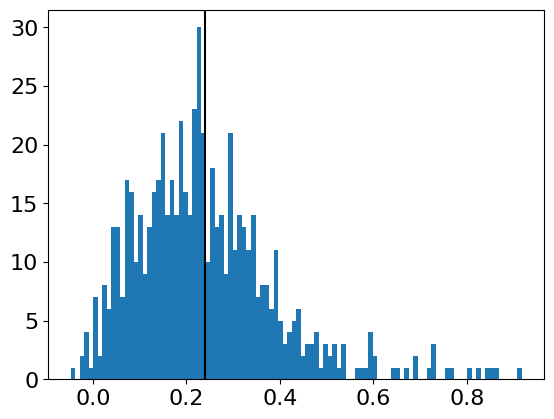

In [109]:
corr = returns.corr().values
tri_a, tri_b = np.triu_indices(len(corr), k=1)
flat_corr = corr[tri_a, tri_b]
plt.hist(flat_corr, bins=100)
plt.axvline(flat_corr.mean(), color='k')
plt.show()

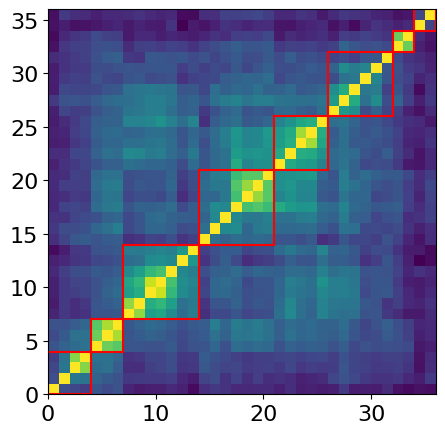

Cluster 1
size: 4
['A', 'C', 'M', 'RM']


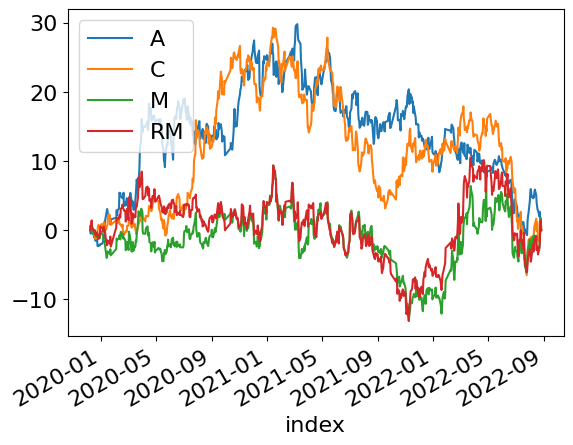

Cluster 2
size: 3
['OI', 'Y', 'P']


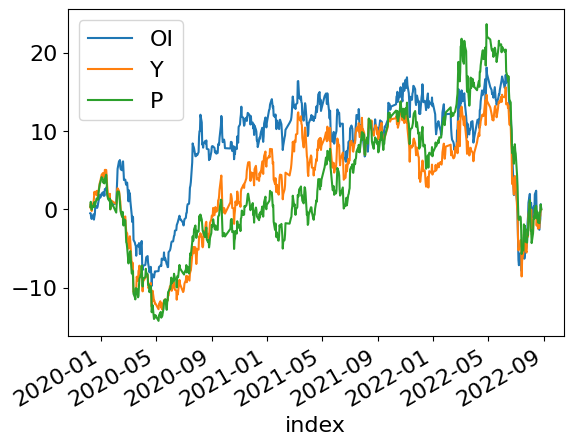

Cluster 3
size: 7
['JM', 'J', 'HC', 'RB', 'I', 'FG', 'SA']


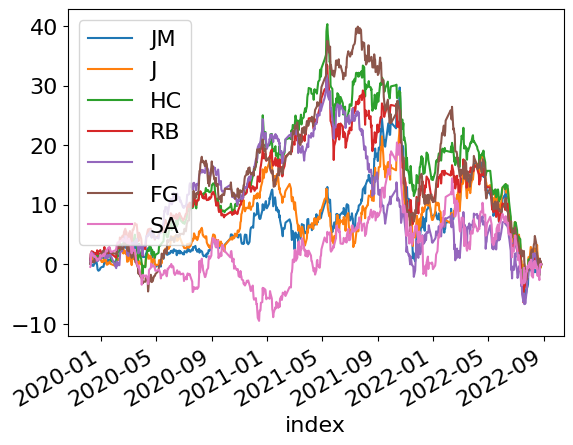

Cluster 4
size: 7
['SR', 'CF', 'RU', 'TA', 'SC', 'FU', 'BU']


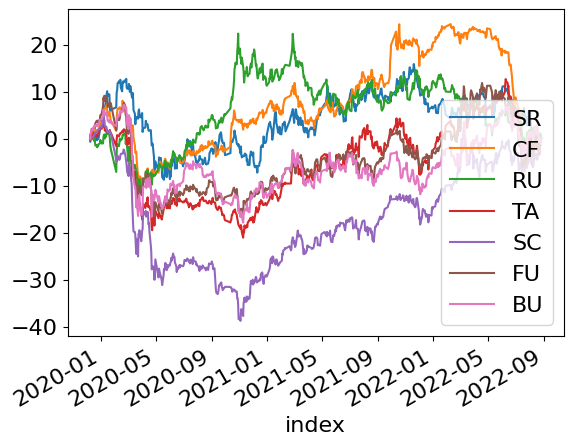

Cluster 5
size: 5
['EG', 'MA', 'PP', 'L', 'V']


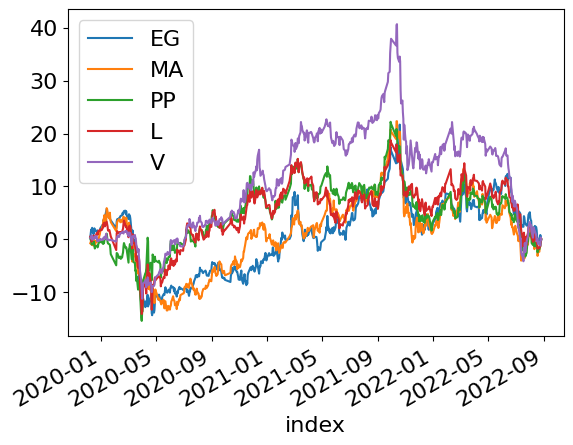

Cluster 6
size: 6
['AL', 'CU', 'ZN', 'NI', 'SN', 'SP']


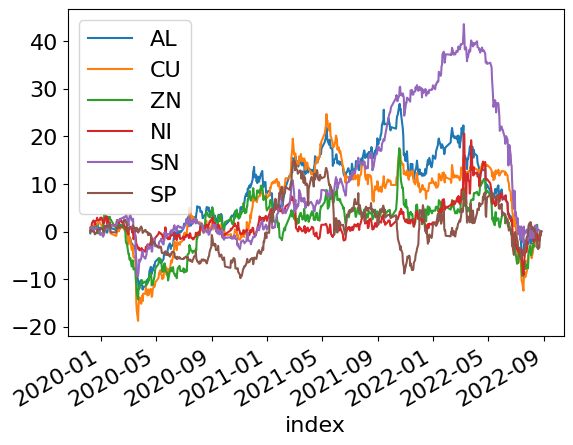

Cluster 7
size: 2
['AG', 'AU']


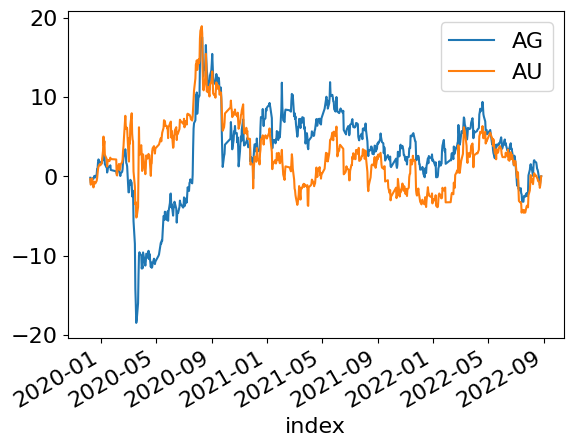

Cluster 8
size: 2
['AP', 'JD']


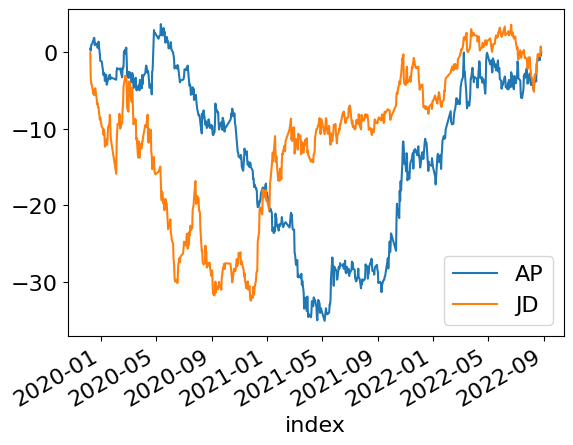

In [120]:
nb_clusters = 8
dist = 1 - sorted_correlations.values
dim = len(dist)
tri_a, tri_b = np.triu_indices(dim, k=1)
linkage = fastcluster.linkage(dist[tri_a, tri_b], method='ward')
clustering_inds = hierarchy.fcluster(linkage, nb_clusters,
                                     criterion='maxclust')
clusters = {i: [] for i in range(min(clustering_inds),
                                 max(clustering_inds) + 1)}
for i, v in enumerate(clustering_inds):
    clusters[v].append(i)



permutation = sorted([(min(elems), c) for c, elems in clusters.items()],
                     key=lambda x: x[0], reverse=False)
sorted_clusters = {}
for cluster in clusters:
    sorted_clusters[cluster] = clusters[permutation[cluster - 1][1]]
    
plt.figure(figsize=(5, 5))
plt.pcolormesh(sorted_correlations)
for cluster_id, cluster in sorted_clusters.items():
    xmin, xmax = min(cluster), max(cluster)
    ymin, ymax = min(cluster), max(cluster)
    
    plt.axvline(x=xmin,
                ymin=ymin / dim, ymax=(ymax + 1) / dim,
                color='r')
    plt.axvline(x=xmax + 1,
                ymin=ymin / dim, ymax=(ymax + 1) / dim,
                color='r')
    plt.axhline(y=ymin,
                xmin=xmin / dim, xmax=(xmax + 1) / dim,
                color='r')
    plt.axhline(y=ymax + 1,
                xmin=xmin / dim, xmax=(xmax + 1) / dim,
                color='r')
plt.show()

coin_to_cluster = {}
for cluster in sorted_clusters:
    print('Cluster', cluster)
    cluster_members = sorted_correlations.columns[sorted_clusters[cluster]].tolist()
    for coin in cluster_members:
        coin_to_cluster[coin] = cluster
    print(f'size: {len(cluster_members)}')
    print(cluster_members)
    returns[cluster_members].cumsum().plot(legend=(len(cluster_members) < 20))
    plt.show()

# everything is sorted, no need to preserve old permutation
returns.columns = sorted_correlations.columns
sorted_correlations.columns = sorted_correlations.columns
sorted_correlations.index = sorted_correlations.columns

In [112]:
eigen_clusters = {}
for cluster in clusters:
    cluster_members = sorted_correlations.columns[
        sorted_clusters[cluster]].tolist()
    corr_cluster = sorted_correlations.loc[
        cluster_members, cluster_members]
    
    cluster_returns = returns[cluster_members]
    
    eigenvals, eigenvecs = np.linalg.eig(corr_cluster.values)
    
    idx = eigenvals.argsort()[::-1]
    eigenvals = eigenvals[idx]
    eigenvecs = eigenvecs[:, idx]
    
    val1 = eigenvals[0]
    vec1 = eigenvecs[:, 0]
    F1 = (1 / np.sqrt(val1)) * np.multiply(
        vec1, cluster_returns.values).sum(axis=1)
    
    eigen_clusters[cluster] = {
        'tickers': cluster_members,
        'val1': val1,
        'vec1': vec1,
        'F1': F1,}
    
betas = {}
for coin in returns.columns:
    
    coin_returns = returns[coin]
    cluster_F1 = eigen_clusters[coin_to_cluster[coin]]['F1']
    
    reg = LinearRegression(fit_intercept=False).fit(
        cluster_F1.reshape(-1, 1), coin_returns)
    
    beta = reg.coef_[0]
    
    betas[coin] = beta

HPCA_corr = sorted_correlations.copy()
for coin_1 in HPCA_corr.columns:
    beta_1 = betas[coin_1]
    F1_1 = eigen_clusters[coin_to_cluster[coin_1]]['F1']
    for coin_2 in HPCA_corr.columns:
        beta_2 = betas[coin_2]
        F1_2 = eigen_clusters[coin_to_cluster[coin_2]]['F1']
        if coin_to_cluster[coin_1] != coin_to_cluster[coin_2]:
            rho_sector = np.corrcoef(F1_1, F1_2)[0, 1]
            mod_rho = beta_1 * beta_2 * rho_sector
            HPCA_corr.at[coin_1, coin_2] = mod_rho
            HPCA_corr.at[coin_1, coin_2] = mod_rho

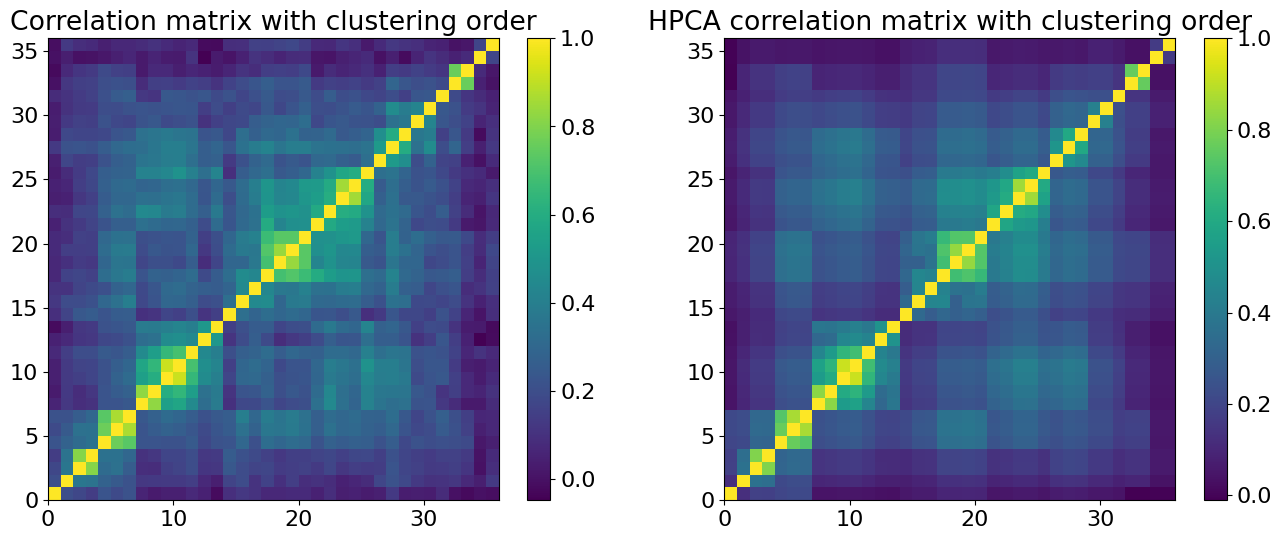

In [113]:
plt.figure(figsize=(16, 6))
plt.subplot(1, 2, 1)
plt.pcolormesh(sorted_correlations)
plt.colorbar()
plt.title('Correlation matrix with clustering order')

plt.subplot(1, 2, 2)
plt.pcolormesh(HPCA_corr)
plt.colorbar()
plt.title('HPCA correlation matrix with clustering order')
plt.show()

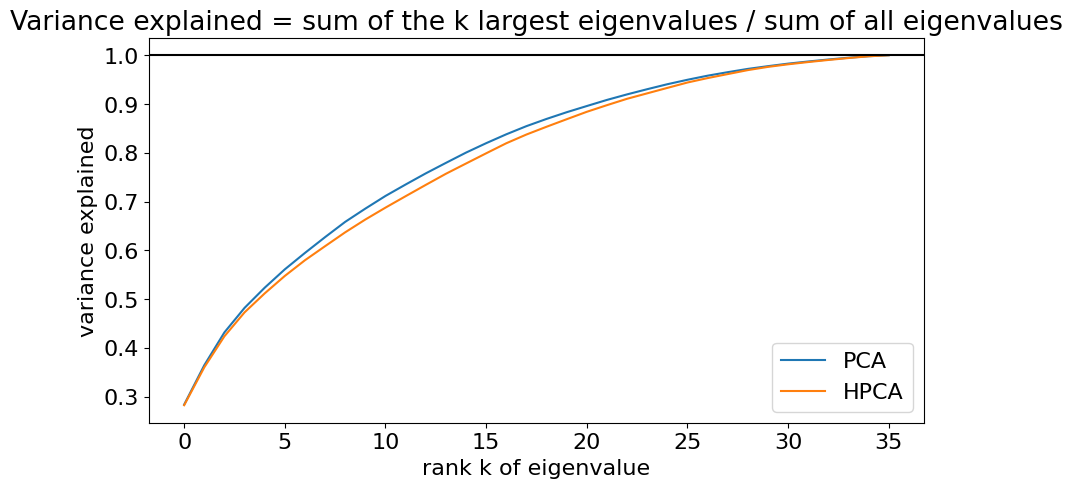

In [114]:
eigenvals, eigenvecs = np.linalg.eig(sorted_correlations.values)

idx = eigenvals.argsort()[::-1]   
pca_eigenvals = eigenvals[idx]
pca_eigenvecs = eigenvecs[:, idx]

eigenvals, eigenvecs = np.linalg.eig(HPCA_corr.values)

idx = eigenvals.argsort()[::-1]   
hpca_eigenvals = eigenvals[idx]
hpca_eigenvecs = eigenvecs[:, idx]
plt.figure(figsize=(10, 5))
plt.plot(np.cumsum(pca_eigenvals) / pca_eigenvals.sum(), label='PCA')
plt.plot(np.cumsum(hpca_eigenvals) / hpca_eigenvals.sum(), label='HPCA')
plt.axhline(1, color='k')
plt.xlabel('rank k of eigenvalue')
plt.ylabel('variance explained')
plt.title('Variance explained = ' +
          'sum of the k largest eigenvalues / sum of all eigenvalues')
plt.legend()
plt.show()

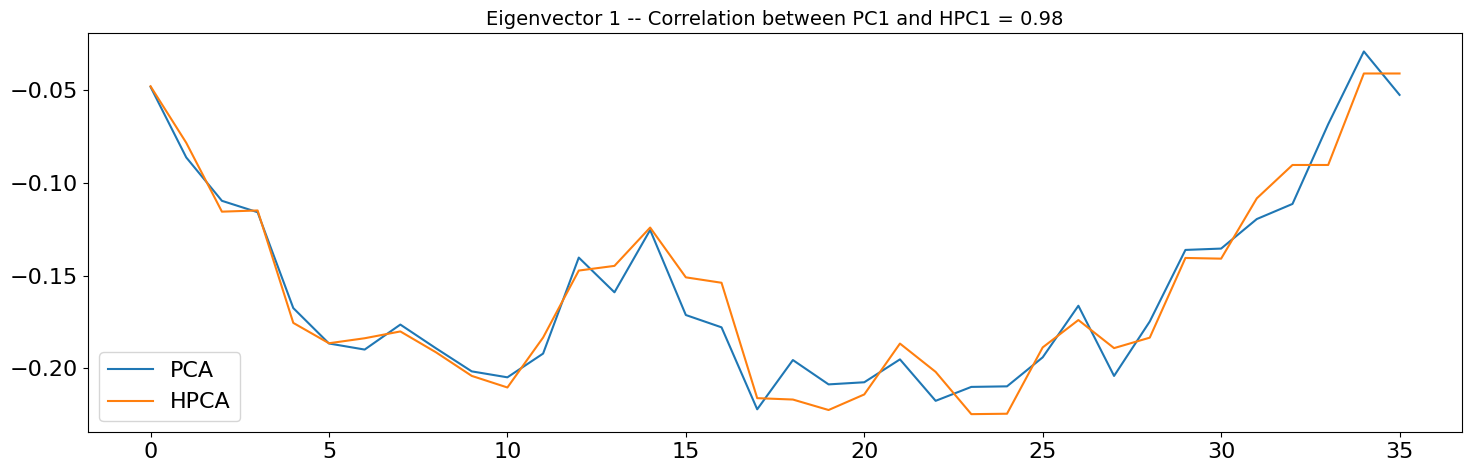

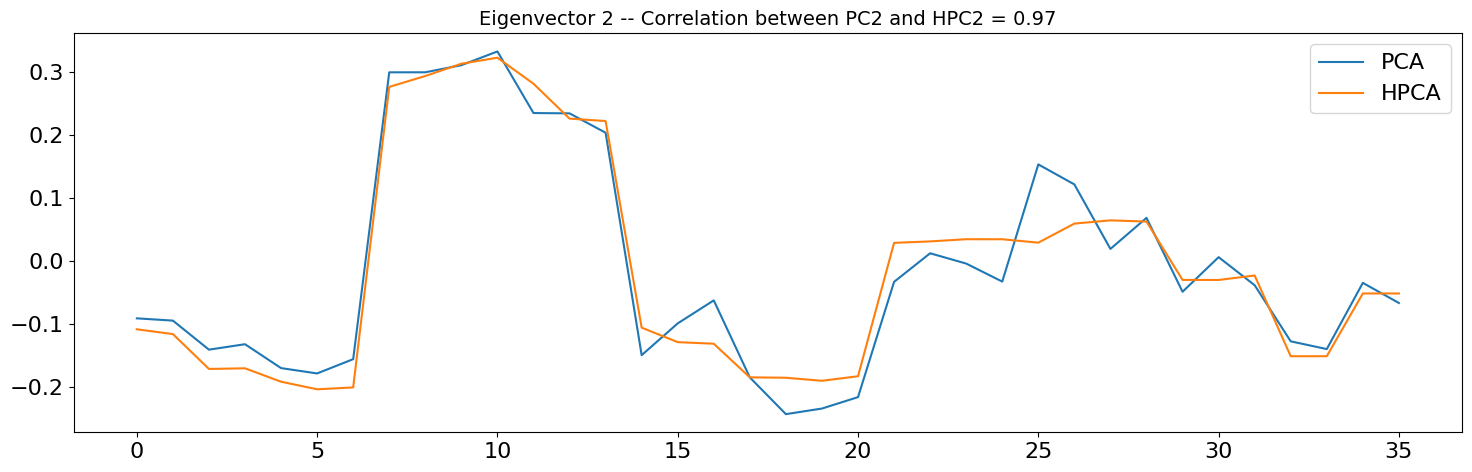

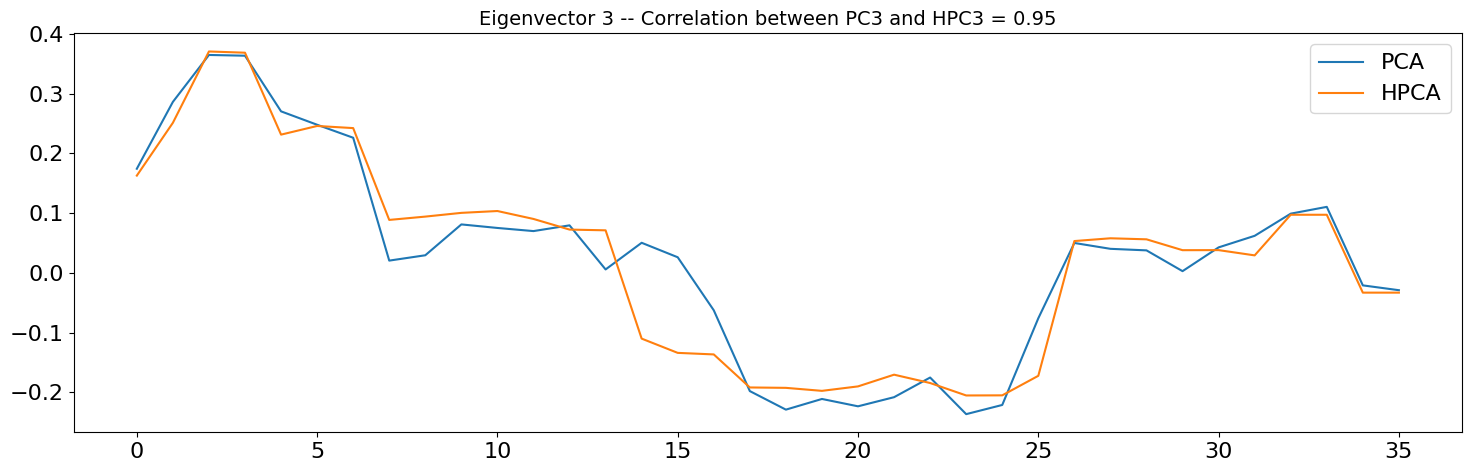

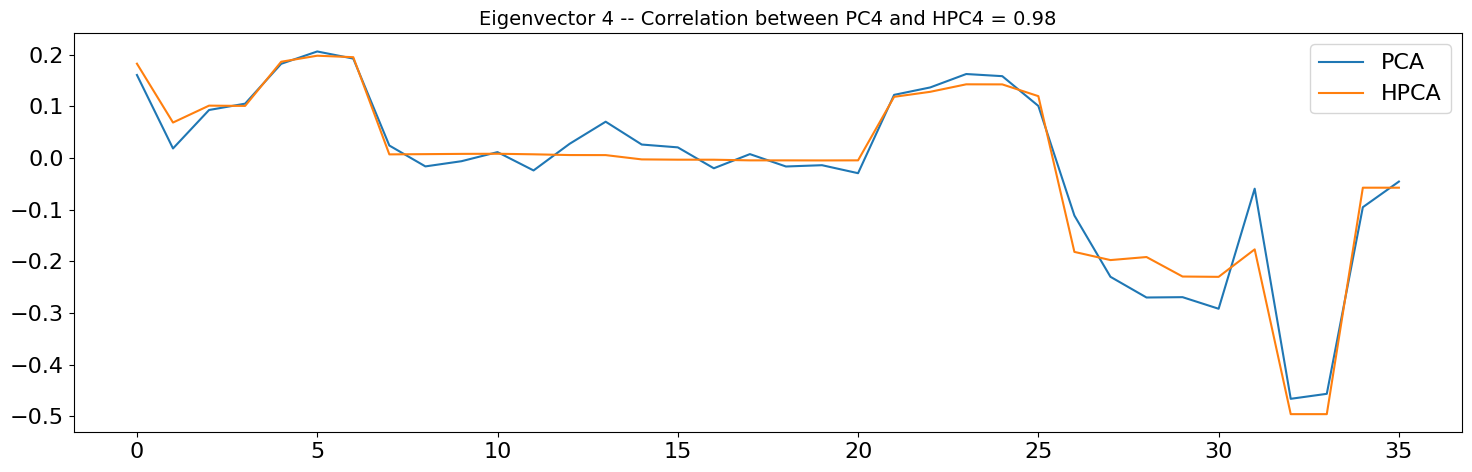

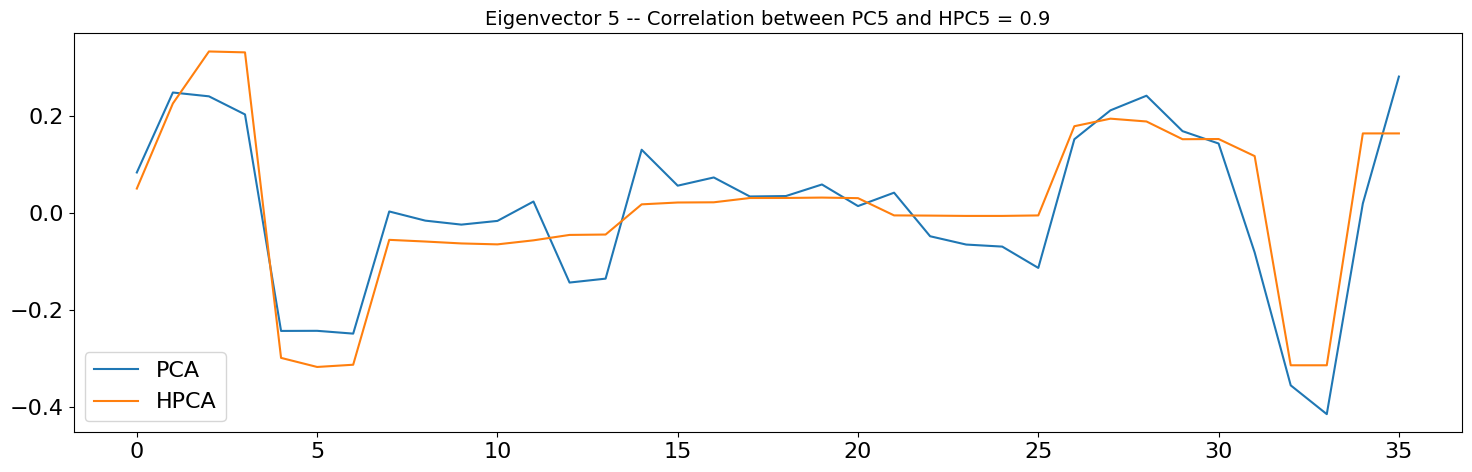

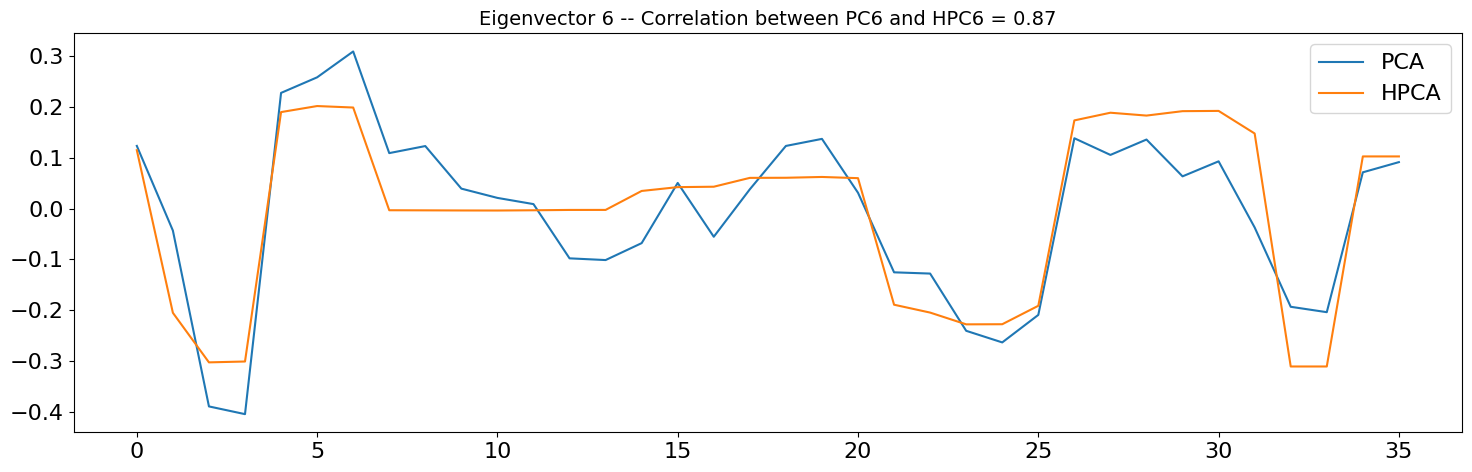

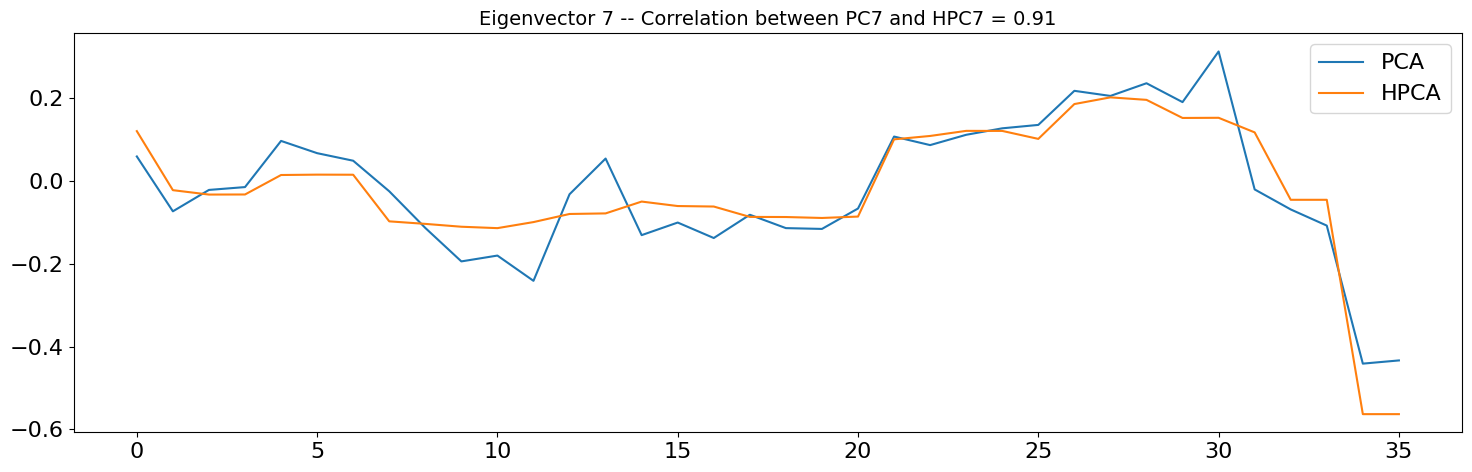

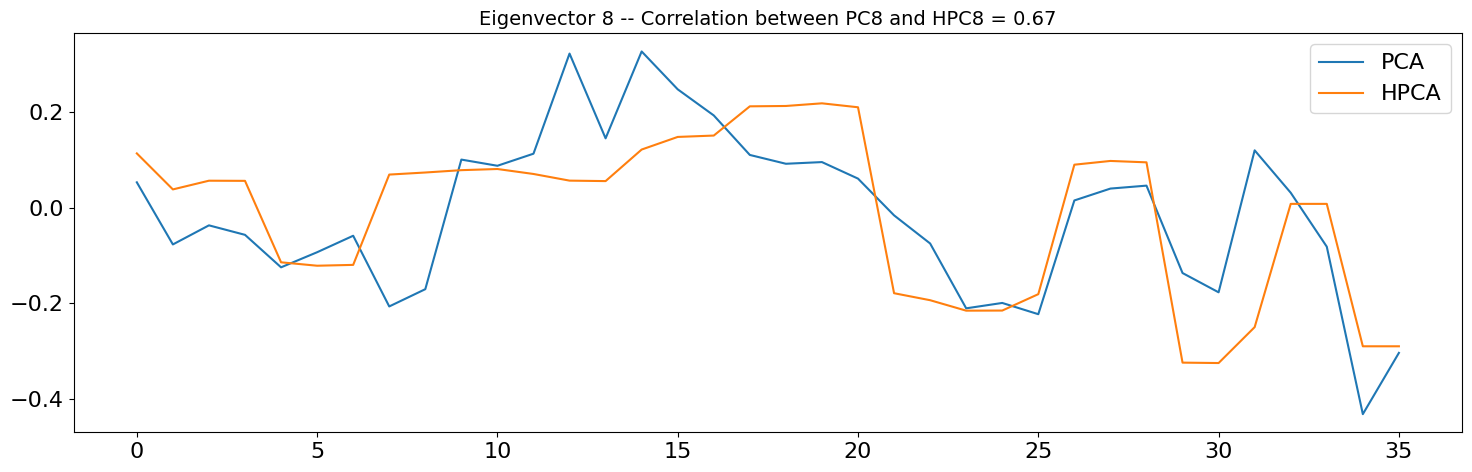

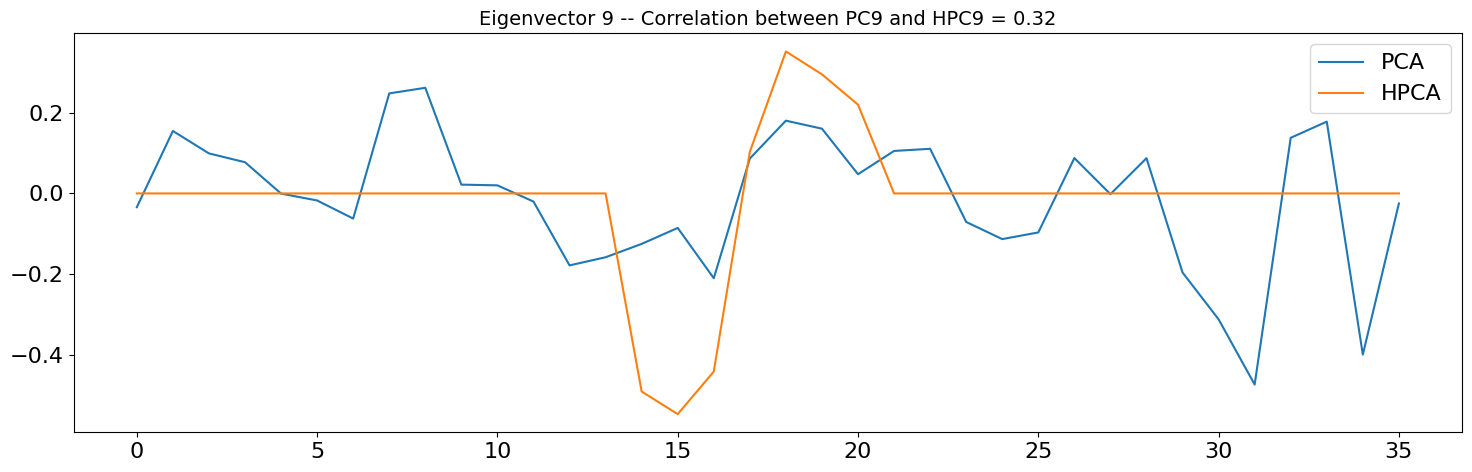

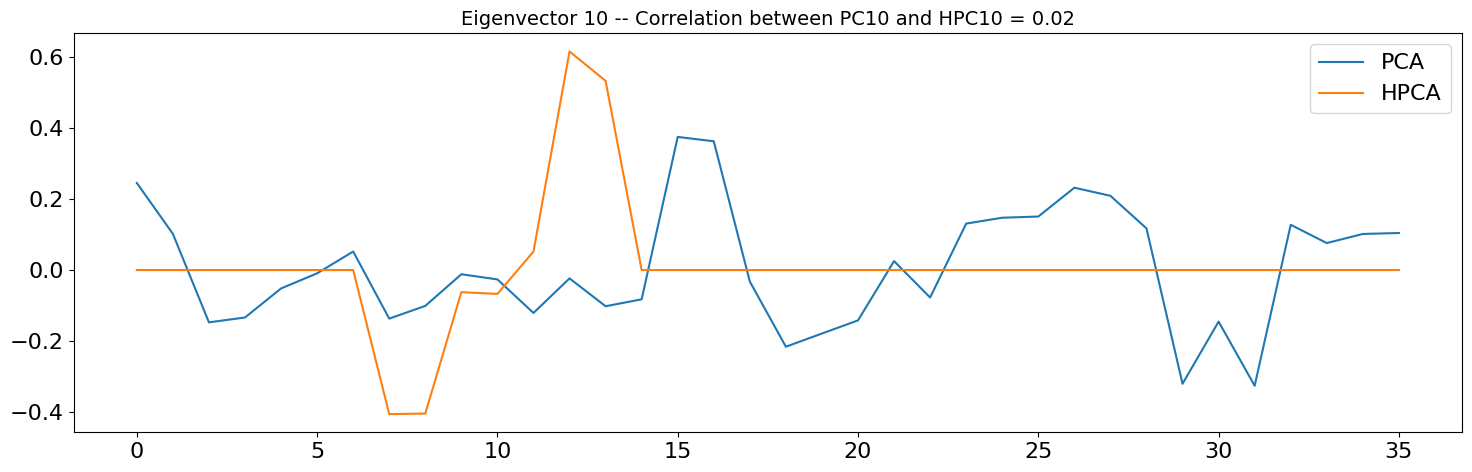

In [115]:
for i in range(10):
    fig, ax = plt.subplots(figsize=(15, 5),
                           tight_layout=True)
    corr_pcs = np.corrcoef(pca_eigenvecs[:, i],
                           hpca_eigenvecs[:, i])[0, 1]
    if corr_pcs < 0:
        hpca_eigenvecs[:, i] = -hpca_eigenvecs[:, i]

    plt.plot(pca_eigenvecs[:, i], label='PCA')
    plt.plot(hpca_eigenvecs[:, i], label='HPCA')
    plt.title('Eigenvector {} -- '.format(i + 1) +
              'Correlation between PC{} and HPC{} = {}'.format(
        i + 1, i + 1, round(abs(corr_pcs), 2)), fontsize=14)
    plt.legend()
    plt.show()

<AxesSubplot: xlabel='index'>

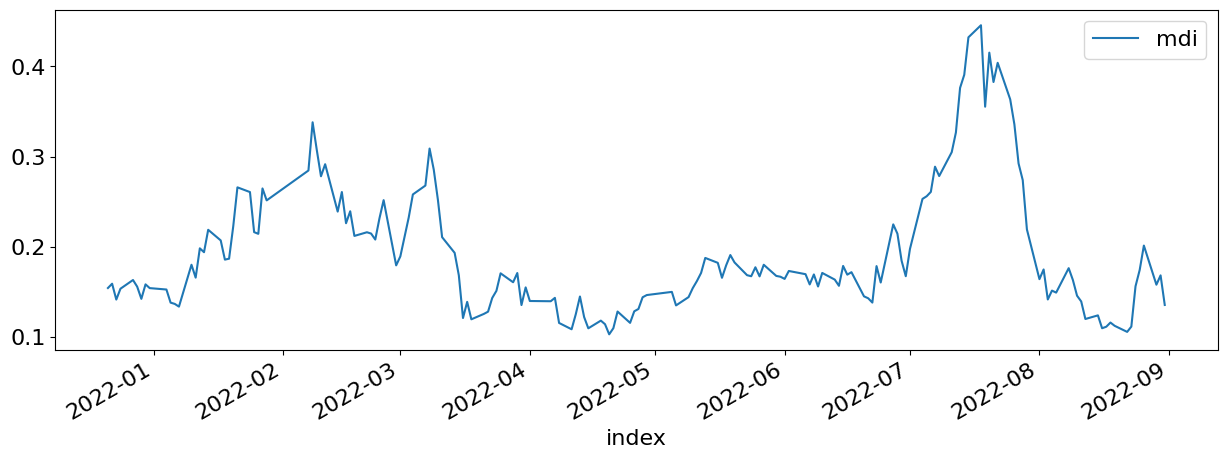

In [413]:

# .tail(200).plot(figsize=(15,5), legend=True)
port = pd.read_csv(r'/Users/weiranzhou/Code/pysystemtrade/ctse/data/strategy_backtest/timeframes.commodity_last_nav.csv')
port.index = pd.to_datetime(port['date'])
port = port['p']
# ((port - port.expanding().max())/port).tail(200).plot(secondary_y=True)
port = port.rolling(term).apply(lambda s: s[-1]/s[0] - 1)
# port.tail(200).plot(secondary_y=True, legend=True)
win = 170
